In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.datasets as Dataset
import torchvision.transforms as transforms

# Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

trainset = Dataset.MNIST(root='.', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=False, num_workers=6)

# Model

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        def block(input_dim, output_dim):
            return nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_dim),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )
        
        def dnn(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim * 3 * 3, 1024),
                nn.ReLU(),
                nn.Dropout(p = 0.3),
                nn.Linear(1024, 10)
            )
        
        self.layer1 = block(1, 64)
        self.layer2 = block(64, 128)
        self.layer3 = block(128, 512)
        self.layer4 = dnn(512)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x.view(-1, 512 * 3 * 3))
        return x
        
classifier = Classifier().cuda()
classifier.load_state_dict(torch.load('model.pkl'))

<All keys matched successfully>

# Saliency

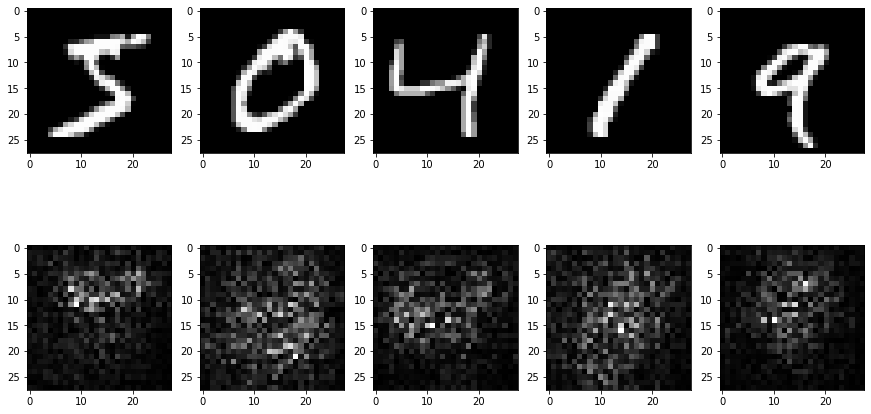

In [10]:
from Explainable import get_saliency
plt_num = 5

images, labels = next(iter(trainloader))
saliencies = get_saliency(images, labels, classifier)

# plot
fig, axes = plt.subplots(2, plt_num, figsize=(15, 8))
for i in range(plt_num):
    axes[0, i].imshow(images[i].squeeze().detach().numpy(), cmap ='gray')
    axes[1, i].imshow(saliencies[i].squeeze(), cmap ='gray')

# Filter explain

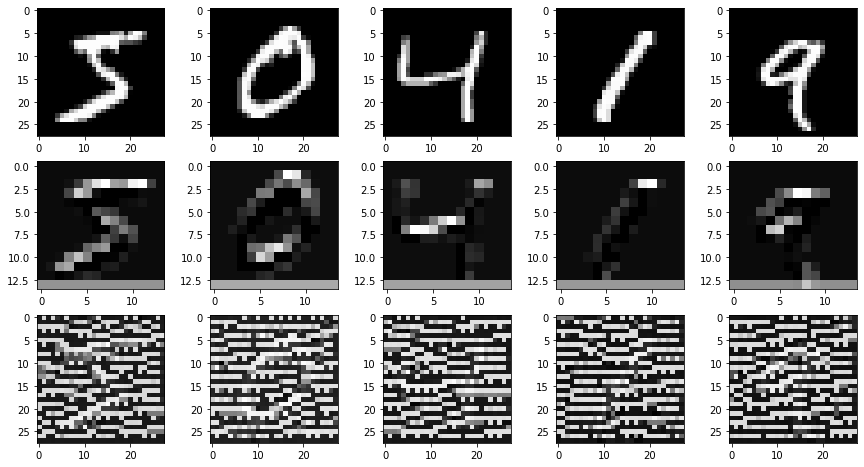

In [9]:
from Explainable import filter_explaination

images, labels = next(iter(trainloader))
fig, axes = plt.subplots(3, plt_num, figsize=(15, 8))

for i in range(plt_num):
    axes[0, i].imshow(images[i].squeeze().detach().numpy(), cmap ='gray')

filter_activations, filter_visualization = filter_explaination(images, classifier, classifier.layer1, filterid=10, iteration=100, lr=0.1)

for i in range(plt_num):
    axes[1, i].imshow(filter_activations[i], cmap ='gray')
    axes[2, i].imshow(filter_visualization[i].numpy(), cmap ='gray')